In [90]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

SEED = 1234
np.random.seed = SEED

Зайдите на http://www.kaggle.com и зарегистрируйтесь. 

Далее вам нужен датасет по этой ссылке: https://www.kaggle.com/c/ghouls-goblins-and-ghosts-boo . И __train__, и __test__, и __sample_submission__. 

Скачайте его и положите рядом с тетрадью, как вам удобнее.

In [2]:
train, test = pd.read_csv(
    'data/HelloKaggle/train.csv'
    # путь к вашему файлу train
), pd.read_csv( 
    'data/HelloKaggle/test.csv'
    # путь к вашему файлу test
)

In [3]:
train.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,1,0.575560,0.425868,0.531401,0.439899,green,Goblin
2,2,0.467875,0.354330,0.811616,0.791225,black,Ghoul
3,4,0.776652,0.508723,0.636766,0.884464,black,Ghoul
4,5,0.566117,0.875862,0.418594,0.636438,green,Ghost


In [4]:
X = train.drop(['id', 'type'], axis=1)
y = train['type']

# К делу!

## Выполним необходимое кодирование

В этот раз я помогу немного :)

### Метки классов

In [28]:
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

In [6]:
answers_encoder = LabelEncoder()
y = answers_encoder.fit_transform(y)

In [7]:
y[:5] # вместо строк получились метки классов

array([1, 2, 1, 1, 0], dtype=int64)

In [8]:
answers_encoder.classes_ # - здесь наши классы все еще лежат

array(['Ghost', 'Ghoul', 'Goblin'], dtype=object)

Используйте метод __inverse_transform__, чтобы превратить предсказания алгоритмов (числа) обратно в строки:

In [9]:
from sklearn.linear_model import LogisticRegression

answers_encoder.inverse_transform(
    # сюда массив с предсказаниями
)

```python
# типа того:
clf = LogisticRegression()
clf.fit(X_train, y_train);
predicts = clf.predict(X_test)
strings = answers_encoder.inverse_transform(predicts) # <-- !
```

### Теперь все признаки

У нас встретился признак цвета - __color__ - закодируем его так, как я сделал ниже. В этот раз.

In [10]:
def onehot_encode(df_train, df_test, column):
    from sklearn.preprocessing import LabelBinarizer
    
    cs = df_train.select_dtypes(include=['O']).columns.values
    if column not in cs:
        return (df_train, df_test, None)

    rest = [x for x in df_train.columns.values if x != column]

    lb = LabelBinarizer()
    train_data = lb.fit_transform(df_train[column])
    test_data = lb.transform(df_test[column])
    new_col_names = ['%s_%s' % (column, x) for x in lb.classes_]

    if len(new_col_names) != train_data.shape[1]:
        new_col_names = new_col_names[::-1][:train_data.shape[1]]

    new_train = pd.concat((df_train.drop([column], axis=1), pd.DataFrame(data=train_data, columns=new_col_names)), axis=1)
    new_test = pd.concat((df_test.drop([column], axis=1), pd.DataFrame(data=test_data, columns=new_col_names)), axis=1)
    return (new_train, new_test, lb)

In [11]:
X.head(2)

,bone_length,rotting_flesh,hair_length,has_soul,color
0,0.354512,0.350839,0.465761,0.781142,clear
1,0.575560,0.425868,0.531401,0.439899,green


In [12]:
X, test, lb = onehot_encode(X, test, 'color')

In [13]:
X.head(2)

,bone_length,rotting_flesh,hair_length,has_soul,color_black,color_blood,color_blue,color_clear,color_green,color_white
0,0.354512,0.350839,0.465761,0.781142,0,0,0,1,0,0
1,0.575560,0.425868,0.531401,0.439899,0,0,0,0,1,0


In [14]:
test.head(2) 

,id,bone_length,rotting_flesh,hair_length,has_soul,color_black,color_blood,color_blue,color_clear,color_green,color_white
0,3,0.471774,0.387937,0.706087,0.698537,1,0,0,0,0,0
1,6,0.427332,0.645024,0.565558,0.451462,0,0,0,0,0,1


Мы превратили все признаки в числовой вид, и с этим можно работать!

# Визуализация

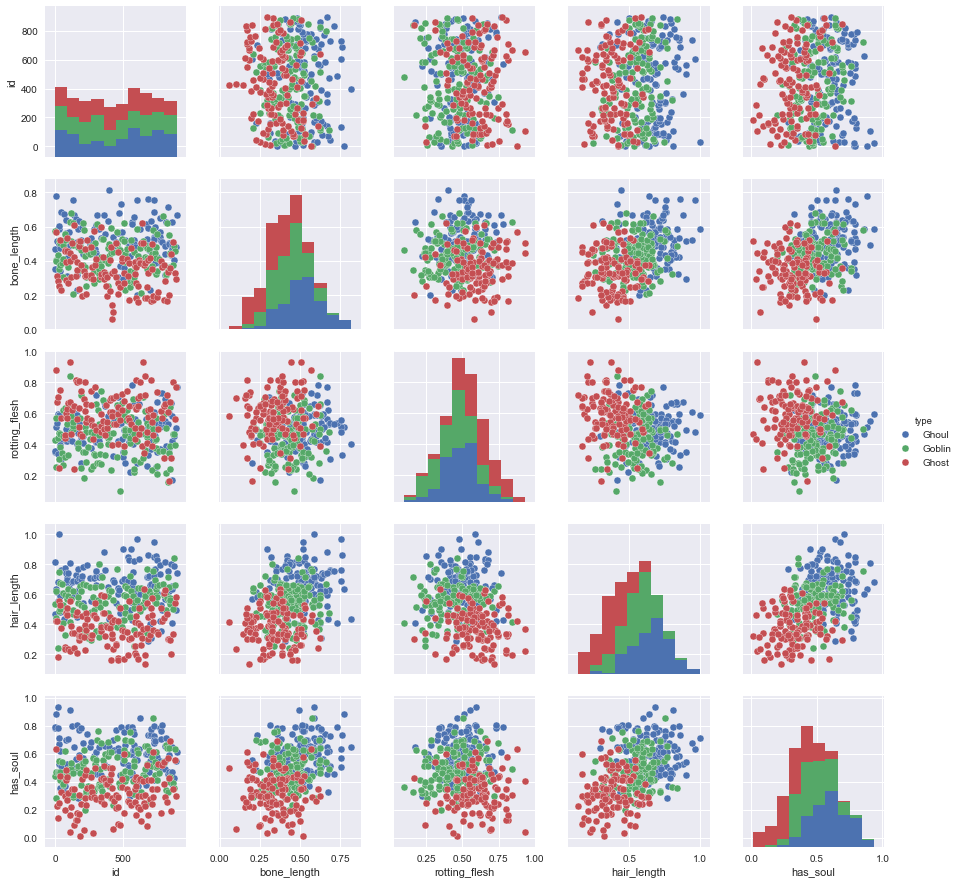

In [15]:
sns.pairplot(train, hue='type');

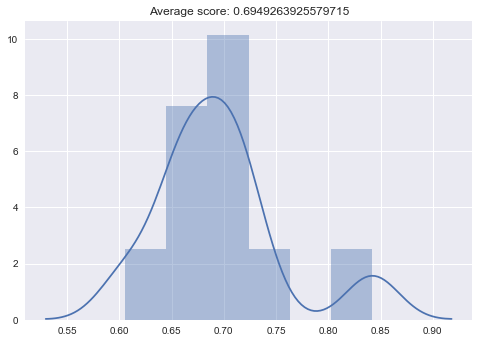

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold

clf = LogisticRegression()
cv_scores = cross_val_score(clf, X, y, cv=10)
sns.distplot(cv_scores);
plt.title('Average score: {}'.format(np.mean(cv_scores)));

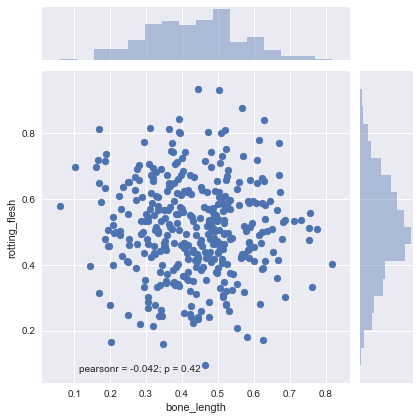

In [17]:
sns.jointplot(x='bone_length', y='rotting_flesh', data=train);

# Классификация

### Получим что-нибудь пригодное для Kaggle

In [117]:
train, test = pd.read_csv(
    'data/HelloKaggle/train.csv'
    # путь к вашему файлу train
), pd.read_csv( 
    'data/HelloKaggle/test.csv'
    # путь к вашему файлу test
)

np.random.seed = 1234

#Закодировали цвет цифрами вместо названий в test & train
colorenc = preprocessing.LabelEncoder()
colorenc.fit(pd.concat((test['color'], train['color'])))
test['color'] = colorenc.transform(test['color'])
train['color'] = colorenc.transform(train['color'])

#Закодировали типы существ цифрами вместо названий в test & train
monsterenc = preprocessing.LabelEncoder()
monsterenc.fit(train['type'])
train['type'] = monsterenc.transform(train['type'])

from sklearn.model_selection import cross_val_score
poly_features = preprocessing.PolynomialFeatures(3)

#Подготовили данные так, что X_tr - таблица без id и type, а в y_tr сохранены type
X_tr, y_tr = train.drop(['id', 'type'], axis=1), train['type']

#Типа перевели dataFrame в array и сдалали над ним предварительную обработку
X_tr = poly_features.fit_transform(X_tr)

## Logistic Regression

In [118]:
from sklearn.linear_model import LogisticRegression
typelogfit = LogisticRegression()
scores = cross_val_score(typelogfit, X_tr, y_tr)
typelogfit.fit(X_tr, y_tr)
print('Best score:', scores.min())

Best score: 0.715447154472


## Logistic Regression + Gridsearch

In [119]:
clf = LogisticRegression()

parameter_grid = {  }
cross_validation = StratifiedKFold(n_splits=10, random_state=SEED)

grid_search = GridSearchCV(clf,
                           param_grid=parameter_grid,
                           cv=cross_validation)
grid_search.fit(X_tr, y_tr);
print('Best score: {}'.format(grid_search.best_score_))

Best score: 0.7304582210242587


## Nearest Neighbour

Best score: 0.593495934959


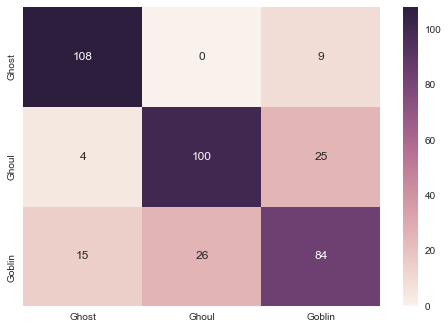

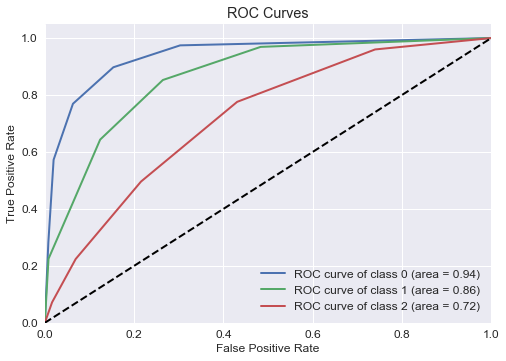

In [120]:
from sklearn.neighbors import KNeighborsClassifier
typeNN = KNeighborsClassifier()
scores = cross_val_score(typeNN, X_tr, y_tr)
typeNN.fit(X_tr, y_tr)
print('Best score:', scores.min())

# confusion matrix
from sklearn.metrics import confusion_matrix
y_tr_pr = typeNN.predict(X_tr)
cm = pd.DataFrame(confusion_matrix(y_tr, y_tr_pr),
                  index=monsterenc.classes_,
                  columns=monsterenc.classes_)
sns.heatmap(cm, annot=True, fmt="d")

#ROC-AUC
from scikitplot import classifier_factory

typeNN = classifier_factory(typeNN)
typeNN.plot_roc_curve(X_tr, y_tr, cv=10, random_state=1, curves=('each_class'));

#Kaggle save
X_te = poly_features.fit_transform(test.drop(['id'], axis=1))
y_te = typeNN.predict(X_te)
ans_nn = pd.DataFrame({'id': test['id'], 'type': monsterenc.inverse_transform(y_te)})
ans_nn.to_csv('ans_NN.csv', index=False)

## Nearest Neighbour + Gridsearch

In [121]:
parameter_grid = {  }
cross_validation = StratifiedKFold(n_splits=10, random_state=SEED)

clf = KNeighborsClassifier()

grid_search2 = GridSearchCV(clf,
                           param_grid=parameter_grid,
                           cv=cross_validation)
grid_search2.fit(X_tr, y_tr);
print('Best score: {}'.format(grid_search2.best_score_))

Best score: 0.6711590296495957


## SVM

Best score: 0.596774193548


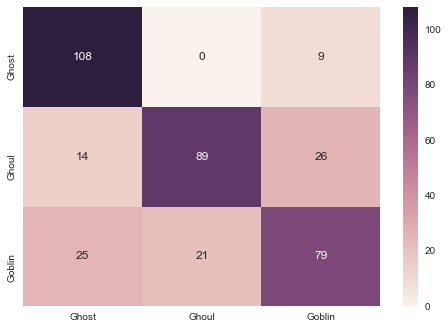

In [122]:
from sklearn.svm import SVC
typeSVM = SVC()
scores = cross_val_score(typeSVM, X_tr, y_tr)
typeSVM.fit(X_tr, y_tr)
print('Best score:', scores.min())

# confusion matrix
y_tr_pr = typeSVM.predict(X_tr)
cm = pd.DataFrame(confusion_matrix(y_tr, y_tr_pr),
                  index=monsterenc.classes_,
                  columns=monsterenc.classes_)
sns.heatmap(cm, annot=True, fmt="d")

#Kaggle save
X_te = poly_features.fit_transform(test.drop(['id'], axis=1))
y_te = typeSVM.predict(X_te)
ans_svm = pd.DataFrame({'id': test['id'], 'type': monsterenc.inverse_transform(y_te)})
ans_svm.to_csv('ans_svm.csv', index=False)


## SVM + Gridsearch

In [123]:
from sklearn.svm import SVC

clf = SVC()

parameter_grid = {  }
cross_validation = StratifiedKFold(n_splits=10, random_state=SEED)

grid_search = GridSearchCV(clf,
                           param_grid=parameter_grid,
                           cv=cross_validation)
grid_search.fit(X_tr, y_tr);
print('Best score: {}'.format(grid_search.best_score_))

Best score: 0.6388140161725068
